<div style="text-align:center">
    <h1>
        REINFORCE
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to implement the Monte Carlo version of Policy Gradient methods. The REINFORCE algorithm uses the full return to update the policy:
</div>

\begin{equation}
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+1} + \cdots + \gamma^{T-t-1} R_{T}
\end{equation}


<br>

In [ ]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import the necessary software libraries:

In [ ]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

## Create and preprocess the environment

### Create the environment

In [ ]:
env = gym.make('CartPole-v0')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [ ]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 4. Actions: 2
Sample state: [-0.04126579  0.00794235 -0.04688772  0.01667579]


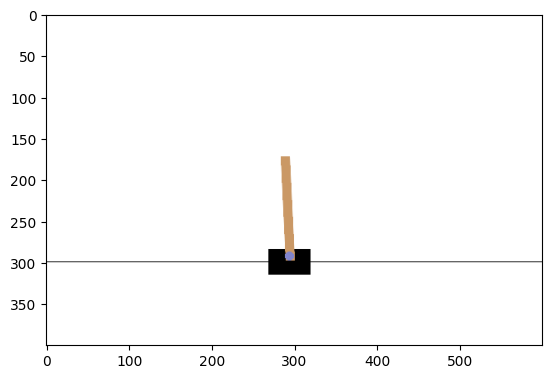

In [ ]:
plt.imshow(env.render(mode='rgb_array'))

### Prepare the environment to work with PyTorch

In [ ]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()

    def step(self, actions):
        actions = actions.squeeze().numpy()
        next_state, reward, done, info = self.env.step(actions)
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [ ]:
#to make parallel enviornments
num_envs = os.cpu_count()
parallel_env = gym.vector.make('CartPole-v1', num_envs=num_envs)
seed_everything(parallel_env)
parallel_env = PreprocessEnv(parallel_env)

In [ ]:
parallel_env.reset()

tensor([[ 0.0274, -0.0061,  0.0359,  0.0197],
        [ 0.0152, -0.0456, -0.0480,  0.0339]])

### Create the policy $\pi(s)$

In [ ]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1))

### Plot action probabilities

In [ ]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

#### Plot a neutral environment

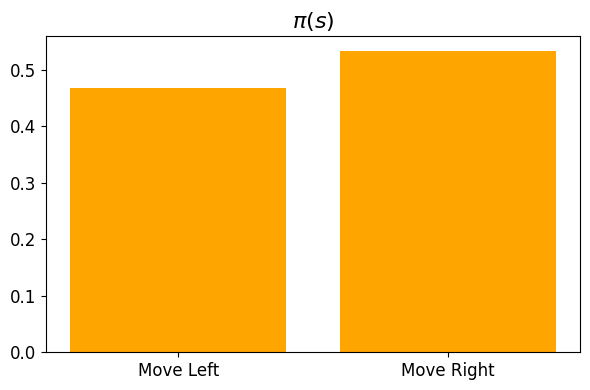

In [ ]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

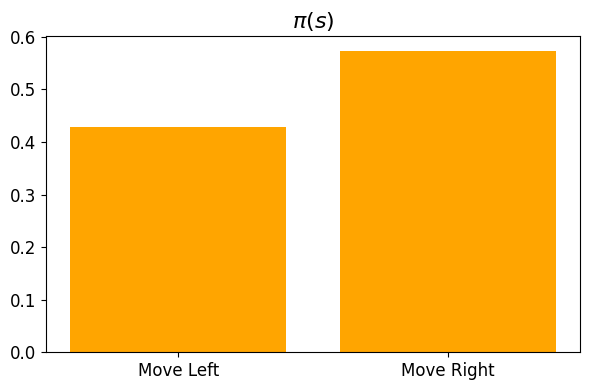

In [ ]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

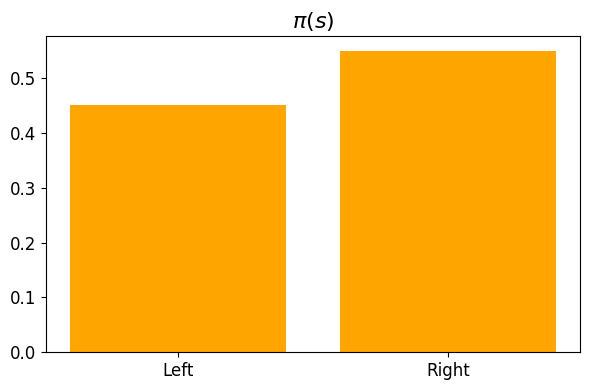

In [ ]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

## Implement the algorithm

In [ ]:
#policy,episodes,learning rate,discount factor
#updating parameters of NN.
#stats_stored-: PG LOSS, Returns
#get the inital state from all parallel agents
#done_b will store column vector with zeroes.
#transitions,ep_returns initialized
#selecting a random action, taking out reward, next_state
#appending transitions, and changing ep_return for all parallel enviornments
#returns to be 0 for all env
#return of transition, prob_t for each env with respect to state, action_prob
#then log the prob.,add very small constant
#for the action that was given by each env we will select the prob. of that action
#calculate the entropy for all env
#calculate gamma raise to t
#estimate of policy gradient loss and total_loss with mean on each env.
def reinforce(policy, episodes, alpha=1e-4, gamma=0.99):
    optim = AdamW(policy.parameters(), lr=alpha)
    stats = {'PG Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        transitions = []
        ep_return = torch.zeros((num_envs, 1))

        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b * reward])
            ep_return += reward
            done_b |= done
            state = next_state

        G = torch.zeros((num_envs, 1))
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)

            entropy_t = - torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma ** t
            pg_loss_t = - gamma_t * action_log_prob_t * G
            total_loss_t = (pg_loss_t - 0.01 * entropy_t).mean()

            policy.zero_grad()
            total_loss_t.backward()
            optim.step()

        stats['PG Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats

In [ ]:
stats = reinforce(policy, 200)

100%|██████████| 200/200 [00:48<00:00,  4.10it/s]


## Show results

### Show execution stats

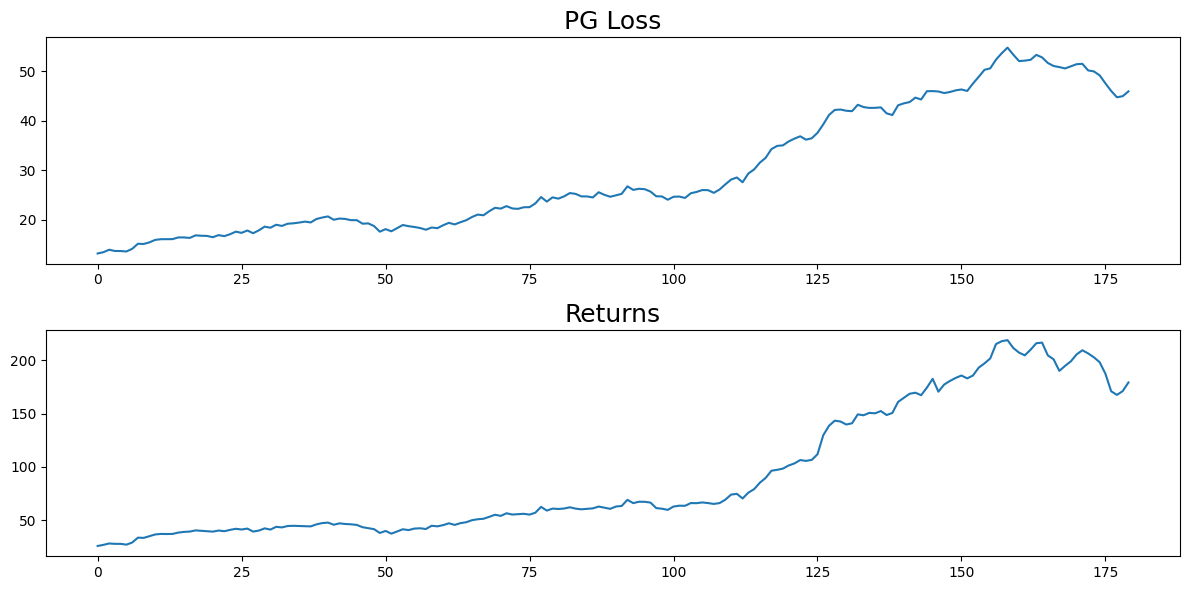

In [ ]:
plot_stats(stats)

### Plot action probabilities

#### Plot a neutral environment

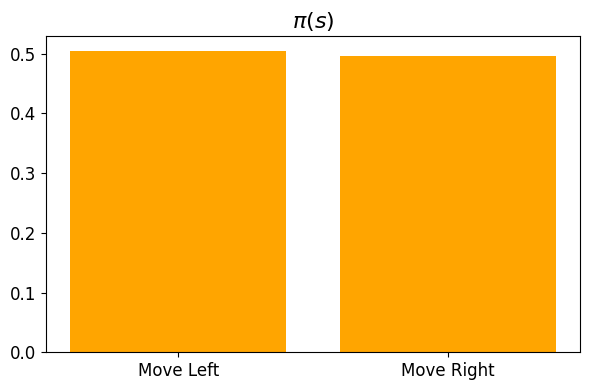

In [ ]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

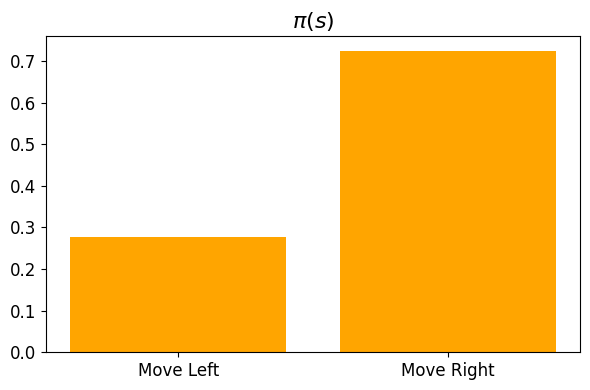

In [ ]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

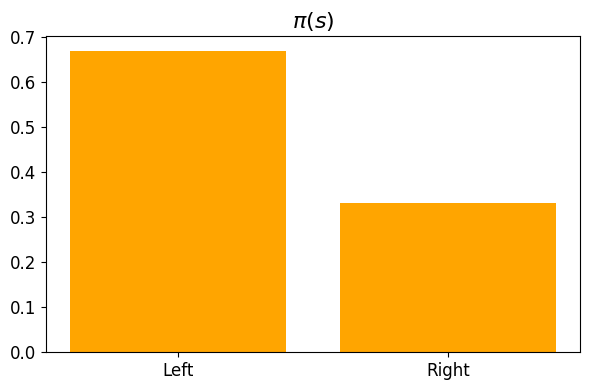

In [ ]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

In [ ]:
test_policy_network(env, policy, episodes=5)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)